In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import readout_explained_var

from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## locate mec and pfc sessions

In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions_temp = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
sessions = pd.DataFrame()
sessions["basepath"] = sessions_temp.basepath.unique()
sessions

,basepath
0,Z:\Data\AYAold\AYA10\day27
1,Z:\Data\AYAold\AYA10\day31
2,Z:\Data\AYAold\AYA10\day32
3,Z:\Data\AYAold\AYA7\day19
4,Z:\Data\AYAold\AYA7\day20
...,...
108,Z:\Data\FujisawaS\EE\EE0705fm
109,Z:\Data\FujisawaS\EE\EE0706fm
110,Z:\Data\FujisawaS\EE\EE0708fm
111,Z:\Data\HMC1\day12


In [66]:
from ripple_heterogeneity.utils import compress_repeated_epochs

basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"
ep_df = loading.load_epoch(basepath)
display(ep_df)
print(np.mean(ep_df.stopTime - ep_df.startTime))

# compress back to back sleep epochs
ep_df = compress_repeated_epochs.main(ep_df, epoch_name="sleep")
display(ep_df)
print(np.mean(ep_df.stopTime - ep_df.startTime))

# locate pre task post structure
idx, _ = functions.find_pre_task_post(ep_df.environment)

ep_df = ep_df[idx]
display(ep_df)
print(np.mean(ep_df.stopTime - ep_df.startTime))

,name,startTime,stopTime,environment,behavioralParadigm
0,EE.185,0.0000,1370.8000,sleep,NaN
1,EE.186,1370.8000,2697.9040,tmaze,Spontaneous alternation task
2,EE.187,2697.9040,4951.5232,sleep,Spontaneous alternation task
3,EE.188,4951.5232,7763.4272,tmaze,Working memory task
4,EE.189,7763.4272,8479.6272,sleep,Working memory task
5,EE.190,8479.6272,10320.3272,sleep,Working memory task
6,EE.191,10320.3272,12526.0232,sleep,Working memory task


1789.4318857142857


,name,startTime,stopTime,environment,behavioralParadigm
0,EE.185,0.0,1370.8,sleep,NaN
1,EE.186,1370.8,2697.904,tmaze,Spontaneous alternation task
2,EE.187,2697.904,4951.5232,sleep,Spontaneous alternation task
3,EE.188,4951.5232,7763.4272,tmaze,Working memory task
4,EE.189,7763.4272,8479.6272,sleep,Working memory task


1695.9254400000002


,name,startTime,stopTime,environment,behavioralParadigm
0,EE.185,0.0,1370.8,sleep,NaN
1,EE.186,1370.8,2697.904,tmaze,Spontaneous alternation task
2,EE.187,2697.904,4951.5232,sleep,Spontaneous alternation task


1650.5077333333331


In [ ]:
basepath = r"Z:\Data\FujisawaS\EE\EE0708fm"
ep_df = loading.load_epoch(basepath)
# locate rows with pattern "sleep" * * "sleep"


In [ ]:
pattern = 
matched = df.rolling(len(pattern)).apply(lambda x: all(np.equal(x, pattern)))
matched = matched.sum(axis = 1).astype(bool)   #Sum to perform boolean OR

In [65]:
np.mean(ep_df.stopTime - ep_df.startTime)


1650.5077333333331

## main analysis

In [49]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_v3_with_post_restrict"
    )

batch_analysis.run(
    sessions,
    save_path,
    readout_explained_var.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

100%|██████████| 113/113 [02:36<00:00,  1.39s/it]


In [50]:
pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)


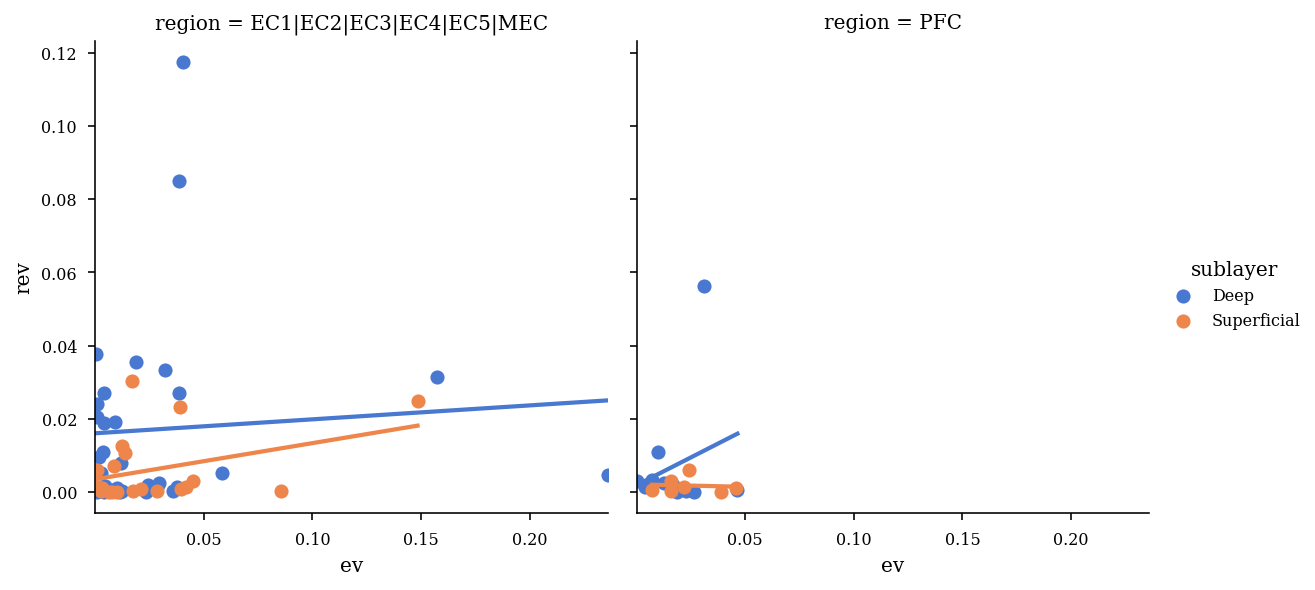

In [51]:
sns.lmplot(x="ev", y="rev", col="region", hue="sublayer", data=ev_df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [52]:
ev_df

,region,sublayer,ev,rev,n_ca1,n_target,basepath
0,EC1|EC2|EC3|EC4|EC5|MEC,Deep,2.868091e-03,0.005196,12.0,10.0,Z:\Data\AYAold\AYA7\day19
1,EC1|EC2|EC3|EC4|EC5|MEC,Deep,2.856993e-02,0.001447,17.0,38.0,Z:\Data\AYAold\AYA7\day20
2,EC1|EC2|EC3|EC4|EC5|MEC,Deep,3.858963e-03,0.026923,19.0,50.0,Z:\Data\AYAold\AYA7\day24
3,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,1.680068e-02,0.030208,7.0,50.0,Z:\Data\AYAold\AYA7\day24
4,EC1|EC2|EC3|EC4|EC5|MEC,Deep,1.178771e-02,0.007969,34.0,79.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
64,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,8.582958e-03,0.007030,18.0,6.0,Z:\Data\Kenji\ec016.532_540
65,EC1|EC2|EC3|EC4|EC5|MEC,Deep,5.842411e-02,0.005186,8.0,7.0,Z:\Data\Kenji\ec016.577_590
66,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,3.968560e-02,0.000880,44.0,7.0,Z:\Data\Kenji\ec016.577_590
67,PFC,Deep,9.417769e-09,0.002964,19.0,13.0,Z:\Data\ORproject\OR18\day1


In [53]:
df_long = pd.DataFrame()
df_long["ev"] = np.hstack([ev_df.ev.values, ev_df.rev.values])
df_long["ev_labels"] = np.hstack([["ev"]*ev_df.ev.shape[0], ["rev"]*ev_df.rev.shape[0]])
df_long["region"] = np.hstack([ev_df.region.values, ev_df.region.values])
df_long["sublayer"] = np.hstack([ev_df.sublayer.values, ev_df.sublayer.values])
df_long["n_ca1"] = np.hstack([ev_df.n_ca1.values, ev_df.n_ca1.values])
df_long["n_target"] = np.hstack([ev_df.n_target.values, ev_df.n_target.values])
df_long["basepath"] = np.hstack([ev_df.basepath.values, ev_df.basepath.values])


df_long

,ev,ev_labels,region,sublayer,n_ca1,n_target,basepath
0,0.002868,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,12.0,10.0,Z:\Data\AYAold\AYA7\day19
1,0.028570,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,17.0,38.0,Z:\Data\AYAold\AYA7\day20
2,0.003859,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,19.0,50.0,Z:\Data\AYAold\AYA7\day24
3,0.016801,ev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,7.0,50.0,Z:\Data\AYAold\AYA7\day24
4,0.011788,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,34.0,79.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
133,0.007030,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,18.0,6.0,Z:\Data\Kenji\ec016.532_540
134,0.005186,rev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,8.0,7.0,Z:\Data\Kenji\ec016.577_590
135,0.000880,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,44.0,7.0,Z:\Data\Kenji\ec016.577_590
136,0.002964,rev,PFC,Deep,19.0,13.0,Z:\Data\ORproject\OR18\day1


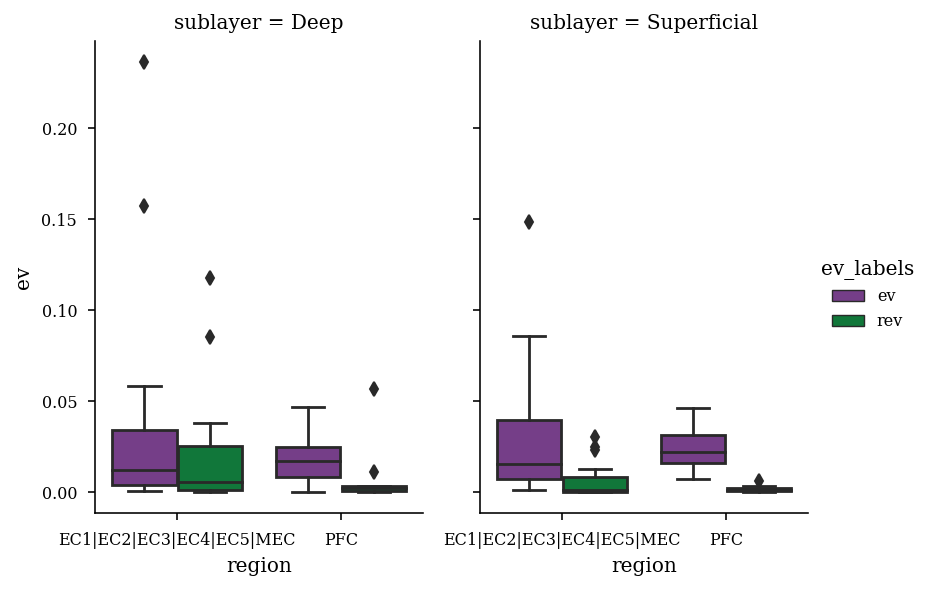

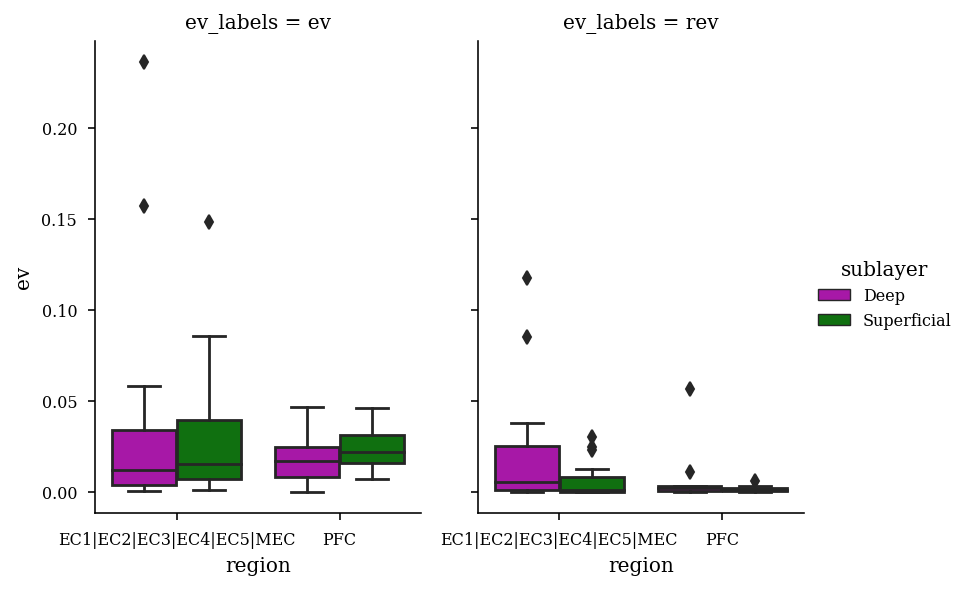

In [54]:
g = sns.catplot(x="region", y="ev",
                hue="ev_labels", col="sublayer",
                data=df_long, kind="box",
                height=4, aspect=.7)
sns.despine()
plt.show()

g = sns.catplot(x="region", y="ev",
                hue="sublayer", col="ev_labels",
                data=df_long, kind="box",palette=["m", "g"],
                height=4, aspect=.7)

# g = sns.catplot(x="region", y="ev",
#                 hue="sublayer", col="ev_labels",
#                 data=df_long,palette=["m", "g"],
#                 height=4, aspect=.7)
sns.despine()
plt.show()

In [55]:
ev_df.basepath.value_counts(), ev_df.region.value_counts() 

ev_df["ev_norm"] = ev_df.ev - ev_df.rev

In [56]:
df_wide = pd.pivot(
    ev_df, index=["region","basepath"], columns="sublayer", values=["ev","rev"]
).reset_index()
df_wide
df_wide["deep_ev_norm"] = df_wide["ev"]["Deep"] - df_wide["rev"]["Deep"]
df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]
df_wide
# ratio between deep and sup normed ev (offset by 1 for ratio)
df_wide["deep_sup_ev_ratio_ev_norm"] = ((df_wide["deep_ev_norm"]+1) - (df_wide["sup_ev_norm"]+1)) / ((df_wide["deep_ev_norm"]+1) + (df_wide["sup_ev_norm"]+1))

df_wide["deep_sup_ev_ratio"] = (df_wide["ev"]["Deep"] - df_wide["ev"]["Superficial"]) / (df_wide["ev"]["Deep"] + df_wide["ev"]["Superficial"])

df_wide["constant"] = 1
df_wide.head(10)

region                   basepath        ev  \
sublayer                                                          Deep   
0         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day19  0.002868   
1         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day20  0.028570   
2         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day24  0.003859   
3         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day12  0.011788   
4         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day15  0.009991   
5         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day16  0.004475   
6         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day17  0.018769   
7         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day10  0.037492   
8         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day12  0.007987   
9         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day13  0.024441   

                           rev             deep_ev_norm sup_ev_norm  \
sublayer Superficial      Deep Superficial                            
0                NaN  0.005196         NaN    -0.002328         NaN   
1                NaN  0.001447         NaN     0.027123         NaN   
2           0.016801  0.026923    0.030208    -0.023064   -0.013407   
3           0.006269  0.007969    0.000069     0.003819    0.006200   
4           0.002525  0.001183    0.000175     0.008808    0.002349   
5           0.012317  0.001631    0.012558     0.002844   -0.000241   
6           0.013544  0.035570    0.010687    -0.016801    0.002857   
7           0.085630  0.001474    0.000187     0.036018    0.085443   
8           0.009817  0.000644    0.000029     0.007343    0.009788   
9           0.028567  0.001998    0.000338     0.022443    0.028229   

         deep_sup_ev_ratio_ev_norm deep_sup_ev_ratio constant  
sublayer                                                       
0                              NaN               NaN        1  
1                              NaN               NaN        1  
2                        -0.004918         -0.626425        1  
3                        -0.001185          0.305655        1  
4                         0.003212          0.596586        1  
5                         0.001540         -0.467007        1  
6                        -0.009898          0.161687        1  
7                        -0.023297         -0.390976        1  
8                        -0.001212         -0.102790        1  
9                        -0.002822         -0.077838        1

In [57]:
from scipy import stats
x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

Ttest_1sampResult(statistic=-1.11576983638682, pvalue=0.28330660795628826)
Ttest_1sampResult(statistic=-0.3764958038248389, pvalue=0.7195030160794147)
Ttest_1sampResult(statistic=-0.5631732507734626, pvalue=0.5822248511471178)
Ttest_1sampResult(statistic=-0.48940771113125386, pvalue=0.6419292850518045)


In [58]:
import statsmodels.formula.api as smf
results = smf.ols('deep_sup_ev_ratio_ev_norm ~ region', data=df_wide).fit()
print(results.summary())



                                OLS Regression Results                               
Dep. Variable:     deep_sup_ev_ratio_ev_norm   R-squared:                       0.017
Model:                                   OLS   Adj. R-squared:                 -0.032
Method:                        Least Squares   F-statistic:                    0.3476
Date:                       Wed, 13 Jul 2022   Prob (F-statistic):              0.562
Time:                               17:18:26   Log-Likelihood:                 59.944
No. Observations:                         22   AIC:                            -115.9
Df Residuals:                             20   BIC:                            -113.7
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [59]:
results = smf.ols('deep_sup_ev_ratio ~ region', data=df_wide).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      deep_sup_ev_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                   0.02106
Date:                Wed, 13 Jul 2022   Prob (F-statistic):              0.886
Time:                        17:18:29   Log-Likelihood:                -13.899
No. Observations:                  22   AIC:                             31.80
Df Residuals:                      20   BIC:                             33.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0793      0.123     -0.643

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=5.621e-01 stat=-5.896e-01


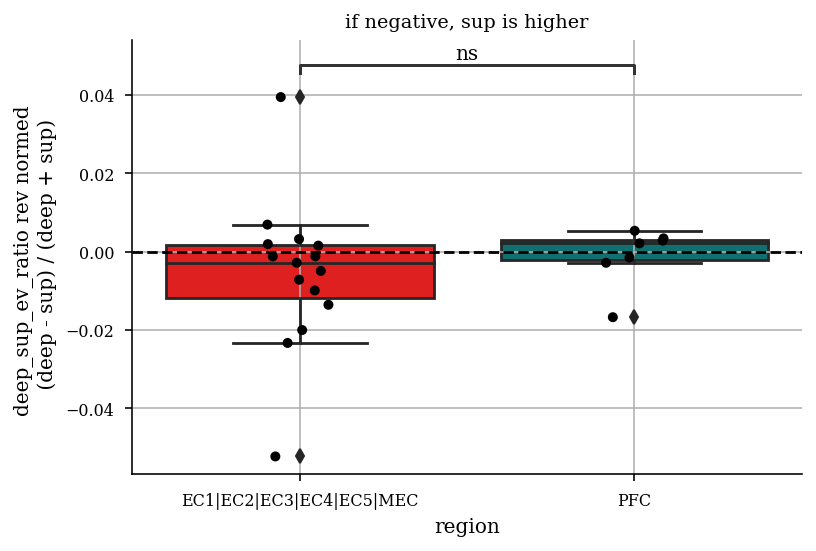

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=8.861e-01 stat=-1.451e-01


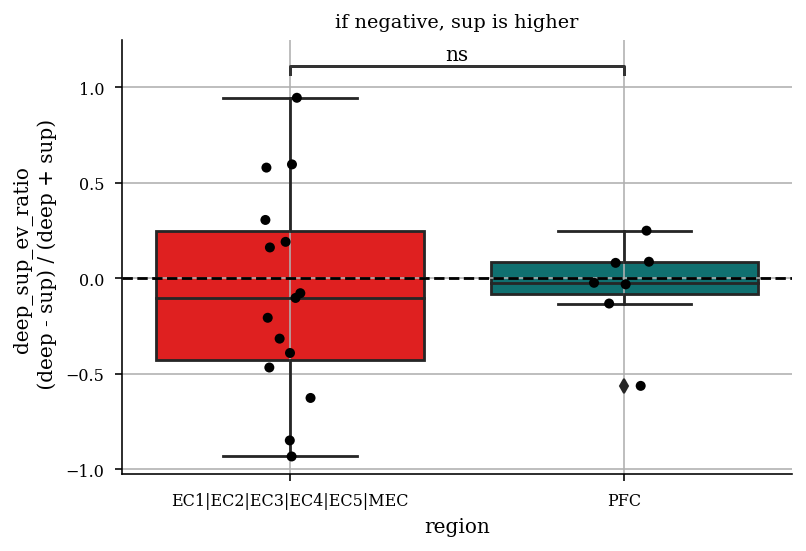

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=3.269e-01 stat=-1.461e+00
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=9.374e-01 stat=-7.302e-01


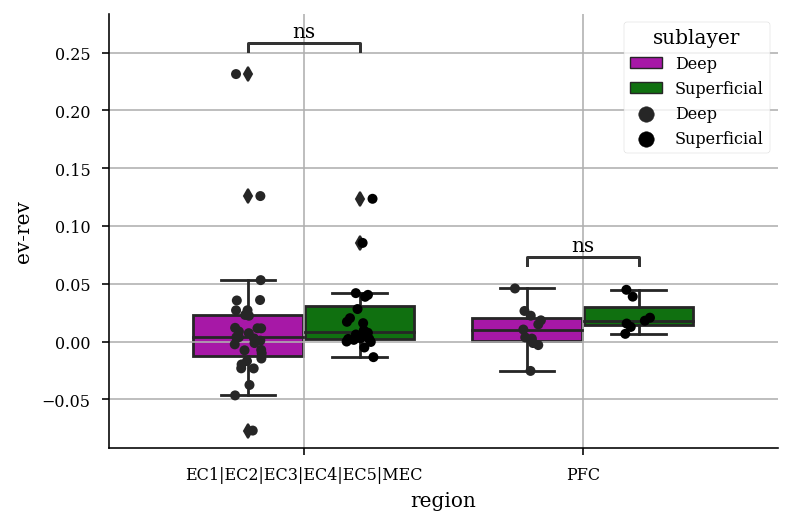

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=6.685e-01 stat=-9.956e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=9.556e-02


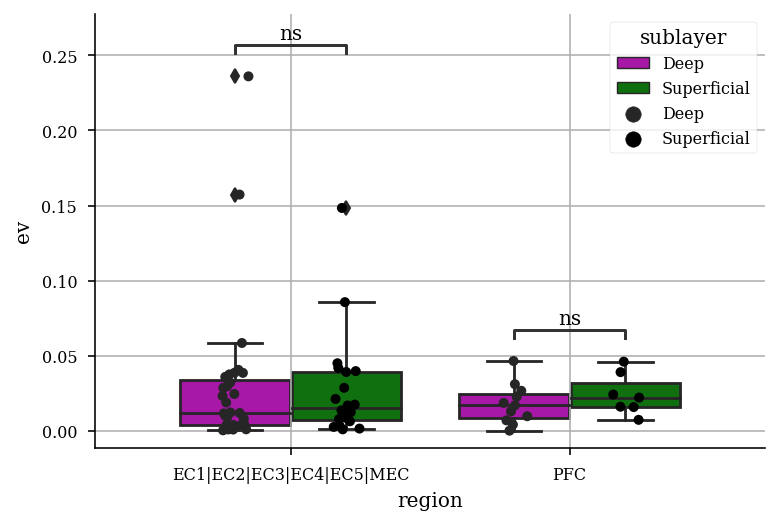

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=7.991e-01 stat=8.655e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.543e-01 stat=1.805e+00


(<AxesSubplot:xlabel='region', ylabel='rev'>,
  <statannot.StatResult.StatResult at 0x21214d9b100>])

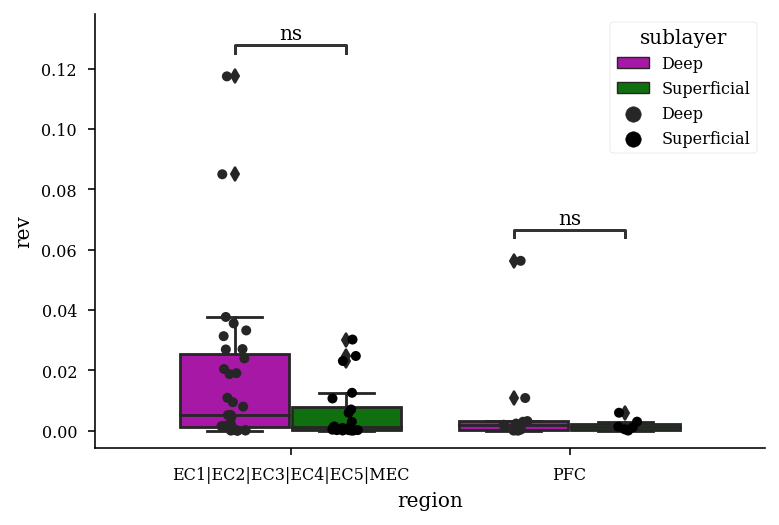

In [60]:
from statannot import add_stat_annotation

sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k')
sns.despine()
plt.ylabel("deep_sup_ev_ratio rev normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="deep_sup_ev_ratio", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio", x="region",color='k',
            data=df_wide,dodge=True)
sns.despine()
plt.ylabel("deep_sup_ev_ratio \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()


sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.ylabel('ev-rev')
plt.grid()
box_pairs=[(("EC1|EC2|EC3|EC4|EC5|MEC", "Deep"), ("EC1|EC2|EC3|EC4|EC5|MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="ev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)

sns.stripplot(y="ev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.grid()
add_stat_annotation(plt.gca(), data=ev_df, y="ev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="rev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="rev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
add_stat_annotation(plt.gca(), data=ev_df, y="rev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=5.621e-01 stat=-5.896e-01


Text(0.5, -1.3910415638018083, '')

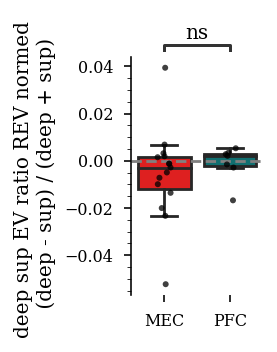

In [61]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

df_wide.loc[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

ax = sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["#de2020", "#116f70"],
            data=df_wide,showfliers=False,saturation=1)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k',size=3,alpha=.75)


sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep sup EV ratio REV normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='grey', linestyle='--')
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["MEC", "PFC"],
                    box_pairs=[("MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_ratio_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.218e-01 U_stat=2.400e+01
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.502e-01 U_stat=2.300e+02


(<AxesSubplot:xlabel='region', ylabel='$EV-REV$'>,
  <statannot.StatResult.StatResult at 0x21201eaca00>])

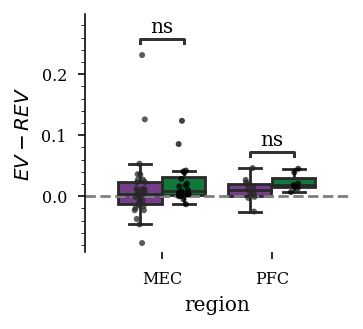

In [62]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ev_df.loc[ev_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", hue_order=group_colors.keys(),
            data=ev_df,showfliers=False)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k',size=3,alpha=.75)
sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('$EV-REV$')
# plt.grid()
plt.axhline(0, color='grey', linestyle='--')
plt.legend("",
    frameon=False,
)
box_pairs=[(("MEC", "Deep"), ("MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )